In [154]:
import numpy as np
import pandas as pd
from datetime import date
from jqdatasdk import *
import jqdatasdk
jqdatasdk.auth('15986661023', '661023')
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook 
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [150]:
display_name = get_all_securities(types=['index'], date=None).display_name
index_dict = {a:b for a, b in zip(display_name, display_name.index)}
pool_index_code = index_dict['沪深300']
START_DATE = "2010-12-31"
END_DATE = date.today()
change_hand_dates = pd.date_range(START_DATE, END_DATE,freq = "6M")
period_start_date = change_hand_dates[0]
period_end_date = change_hand_dates[-1]

In [151]:
period_start_date

Timestamp('2010-12-31 00:00:00', freq='6M')

In [152]:
period_end_date

Timestamp('2019-12-31 00:00:00', freq='6M')

<BarContainer object of 27 artists>

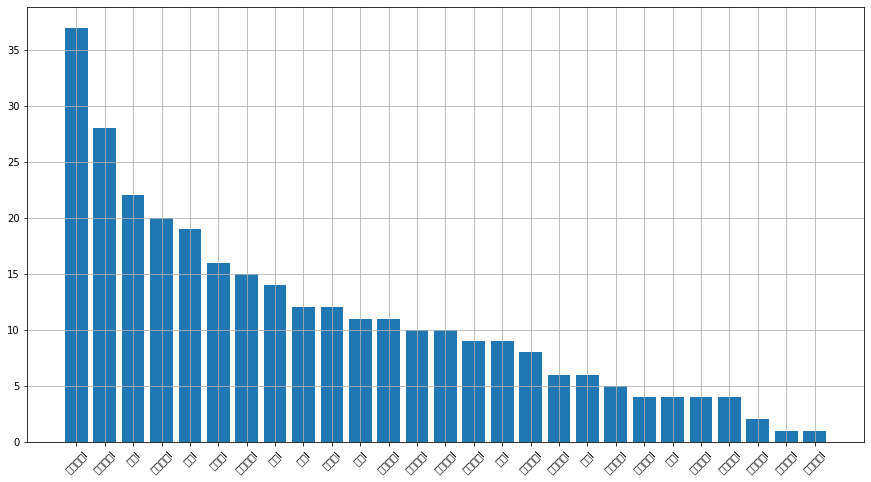

In [138]:
pool_stock_code = get_index_weights(pool_index_code, date=period_start_date).index
ind_s = pd.DataFrame(list(pd.DataFrame(get_industry(list(pool_stock_code))).loc['sw_l1', :]))['industry_name']
plt.figure(figsize = (15, 8))
plt.xticks(rotation=45)
plt.grid()
plt.bar(ind_s.value_counts().index, ind_s.value_counts())

In [139]:
# value_indicator
value_indicator = get_fundamentals(query(
    valuation.code, 
    valuation.pe_ratio,
    valuation.pb_ratio,
    valuation.ps_ratio,
    valuation.pcf_ratio,
#     finance.SW1_DAILY_VALUATION.dividend_ratio
    ).filter(valuation.code.in_(pool_stock_code)), date='2019-11-11')
value_indicator = value_indicator.set_index('code')

# growth_indicator
growth_indicator = get_fundamentals(query(
    indicator.code, 
    indicator.inc_revenue_year_on_year,
    indicator.inc_net_profit_year_on_year,
    
    ).filter(
    # 这里不能使用 in 操作, 要使用in_()函数
    indicator.code.in_(pool_stock_code)
    ), date='2019-11-11')
growth_indicator = growth_indicator.set_index('code')

# market_captical indicator
mc = get_fundamentals(query(
    valuation.code, 
    valuation.market_cap,
    ).filter(
    # 这里不能使用 in 操作, 要使用in_()函数
    indicator.code.in_(pool_stock_code)
    ), date='2019-11-11')
mc = mc.set_index('code')

In [140]:
def get_indicators(pool_stock_code, period_start_date):
    # value_indicator
    value_indicator = get_fundamentals(query(
        valuation.code, 
        valuation.pe_ratio,
        valuation.pb_ratio,
        valuation.ps_ratio,
        valuation.pcf_ratio,
    #     finance.SW1_DAILY_VALUATION.dividend_ratio
        ).filter(
        # 这里不能使用 in 操作, 要使用in_()函数
            valuation.code.in_(pool_stock_code)
        ), date=period_start_date)

    value_indicator = value_indicator.set_index('code')
    
    # growth_indicator
    growth_indicator = get_fundamentals(query(
        indicator.code, 
        indicator.inc_revenue_year_on_year,
        indicator.inc_net_profit_year_on_year,

        ).filter(
        # 这里不能使用 in 操作, 要使用in_()函数
        indicator.code.in_(pool_stock_code)
        ), date=period_start_date)
    growth_indicator = growth_indicator.set_index('code')
    
    # market_captical indicator
    mc = get_fundamentals(query(
        valuation.code, 
        valuation.market_cap,
        ).filter(
        # 这里不能使用 in 操作, 要使用in_()函数
        indicator.code.in_(pool_stock_code)
        ), date=period_start_date)
    mc = mc.set_index('code')
    return(value_indicator, growth_indicator, mc)

value_indicator, growth_indicator, mc = get_indicators(pool_stock_code, '2019-11-11')

In [141]:
def df_min_max_norm(df, smoothing = 0.00001):
    return((df - df.min()) / (df.max() - df.min()) + smoothing)

def df_norm(df):
    return((df-df.mean())/df.std())

extreme_table = value_indicator.quantile([0.05, 0.95])

for aColumn in value_indicator.columns:
    value_indicator.loc[value_indicator[aColumn] > extreme_table.loc[0.95, aColumn], aColumn] = extreme_table.loc[0.95, aColumn]
    value_indicator.loc[value_indicator[aColumn] < extreme_table.loc[0.05, aColumn], aColumn] = extreme_table.loc[0.05, aColumn]


In [142]:
def indicator_preprocess(indicator, do_min_max_norm = False):
    extreme_table = indicator.quantile([0.05, 0.95])
    
    for aColumn in indicator.columns:
        indicator.loc[indicator[aColumn] > extreme_table.loc[0.95, aColumn], aColumn] = extreme_table.loc[0.95, aColumn]
        indicator.loc[indicator[aColumn] < extreme_table.loc[0.05, aColumn], aColumn] = extreme_table.loc[0.05, aColumn]
   
    if not do_min_max_norm:
        norm_indicator = df_norm(indicator)
    else:
        norm_indicator = df_min_max_norm(indicator)
    return(norm_indicator)


In [143]:
norm_growth_indicator = indicator_preprocess(growth_indicator, True)
using_div = False
if not using_div:
    norm_value_indicator = norm_value_indicator.loc[:, ['pe_ratio', 'pb_ratio', 'ps_ratio', 'pcf_ratio']]
V_score = (1/norm_value_indicator).sum(1)
G_score = (norm_growth_indicator).sum(1)

In [145]:
def cal_mc_adjust(aScore, mc):
    R_adjust_score = pd.Series(index = aScore.index)
    for aStock in aScore.index:
        stock_lessthan = aScore.loc[aScore<aScore[aStock]].index
        R_adjust_score[aStock] = (mc.loc[stock_lessthan].sum()+mc.loc[aStock]/2)/mc.sum()
    return(R_adjust_score)

RG_score = cal_mc_adjust(G_score, mc)
RV_score = cal_mc_adjust(V_score, mc)

In [146]:
def plot_benchmark(pool_index_code,  period_start_date, period_end_date, plot = True):
    close = get_price(pool_index_code, start_date=period_start_date, end_date=period_end_date).close
    benchmark_return = (close.pct_change())
    if plot:
        (benchmark_return+1).cumprod().plot()
    return(benchmark_return)


In [204]:
def get_period_return(pool_stock_code, period_start_date, period_end_date):
    m = pd.DataFrame(index = get_price(list(pool_stock_code)[1],  start_date=period_start_date, 
                                       end_date=period_end_date, fields=['pre_close','close']).index)
    for i in range(len(list(pool_stock_code))):
        list_stock_code = list(pool_stock_code)
        stock_code = list_stock_code[i]
        p = get_price(stock_code,  start_date=period_start_date, end_date=period_end_date, 
                        fields=['close', 'pre_close'])
        period_close = p.close
        period_preclose = p.pre_close
        period_return = (period_close-period_preclose)/period_preclose
        period_return = pd.DataFrame(period_return,columns=[stock_code])
        m = pd.concat([m,period_return],axis=1)
    return( m )
period_return = get_period_return(pool_stock_code, period_start_date, period_end_date)

In [207]:
period_return

,000001.XSHE,000002.XSHE,000063.XSHE,000069.XSHE,000100.XSHE,000157.XSHE,000402.XSHE,000408.XSHE,000413.XSHE,000415.XSHE,...,002939.XSHE,002925.XSHE,002945.XSHE,601066.XSHG,603259.XSHG,601319.XSHG,601298.XSHG,002938.XSHE,601577.XSHG,601138.XSHG
2010-12-31,0.007752,0.009772,0.019920,0.006834,0.006993,0.024814,0.008097,0.038496,0.000000,0.005025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,0.013462,0.069355,-0.003348,0.058824,0.013889,0.004843,0.042169,0.026724,0.000000,0.050000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,-0.005693,0.004525,-0.021837,-0.010684,-0.013699,0.038554,0.003854,0.012594,0.000000,0.050000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-06,-0.007634,0.000000,0.001717,0.006479,0.041667,-0.029002,0.005758,0.005804,0.049327,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-07,0.038462,0.006006,0.007429,0.008584,0.006667,-0.010753,0.017176,-0.003298,-0.008547,-0.006803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,-0.006098,-0.002962,0.019022,-0.005398,0.002237,0.015552,-0.007500,-0.014946,-0.008671,-0.008043,...,-0.004471,0.000903,-0.013981,-0.004998,-0.009777,-0.005413,-0.010234,-0.009724,-0.001125,0.011752
2019-12-26,0.010429,0.027402,0.004444,0.021710,0.046875,-0.001531,0.010076,-0.006897,-0.008746,0.005405,...,0.020958,-0.006316,0.023633,0.094726,0.021942,0.010884,0.004431,-0.012051,0.013514,-0.004425
2019-12-27,0.009715,-0.003856,-0.007670,0.007968,-0.036247,0.003067,-0.001247,0.013889,0.035294,-0.002688,...,-0.024194,-0.035414,-0.033641,-0.055719,-0.020719,0.000000,-0.008824,-0.005873,-0.004444,-0.027222
2019-12-30,-0.003608,0.018387,0.021106,0.025033,-0.013274,0.006116,0.008739,0.026027,-0.034091,0.021563,...,0.030804,0.026594,0.027986,0.074280,-0.002521,0.025572,0.007418,0.014997,0.008929,0.005140


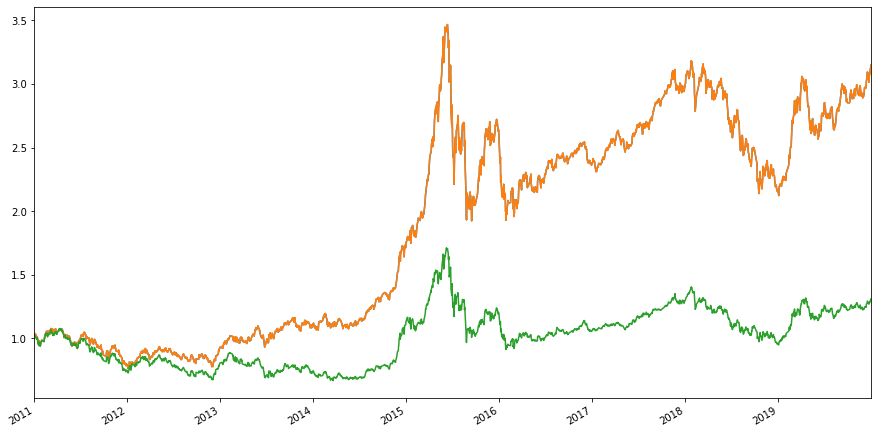

In [266]:
score = pd.concat([RV_score,RG_score],axis=1).dropna()
score.columns=['RV_score','RG_score']
plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.plot((period_return[(score['RV_score']>score['RG_score']).index]+1).cumprod().mean(1))
ax.plot((period_return[(score['RV_score']<score['RG_score']).index]+1).cumprod().mean(1))
benchmark = plot_benchmark(pool_index_code, period_start_date, period_end_date)